# Optimal Brain Surgeon for MLP

This notebook implements sensitivity based pruning after the methods in [Second order derivatives for network pruning: Optimal Brain Surgeon by Hassibi and Stork](https://proceedings.neurips.cc/paper/1992/hash/303ed4c69846ab36c2904d3ba8573050-Abstract.html)

The sensitivity $L_q$ of the $q^{th}$ parameter is

$L_q = \frac{1}{2} \frac{w_q^2}{[H^{-1}]_{qq}}$.

The optimal weight change is

$\delta w = - \frac{w_q}{[H^{-1}]_{qq}} H^{-1} \cdot e_q$.

---

1. Train a "reasonably large" network to minimum error
2. Compute $H^{-1}$
3. Find the $q$ that gives the smallest salience $L_q$. If this candidate error increase is much smaller than error $E$, then the $q^{th}$ weight should be deleted, and we proceed to step 4; otherwise go to step 5. (Other stopping criteria can be used too.)
4. Use the $q$ from step 3 to update *all* weights. Go to step 2.
5. No more weights can be deleted without large increase in E. (At this point, it may be desirable to retrain the network.)


In [1]:
def compute_param_sensitivity(param, hessian_inv):
    param_sensitivity = []
    for i in range(len(param)):
        if np.round(hessian_inv[i, i], 10) == 0.0:
            # print(f"Warning: Hessian inverse at index {i} is zero, skipping sensitivity calculation.")
            param_sensitivity.append(float('inf'))
            continue
        L_q = 0.5 * (param[i] ** 2) / hessian_inv[i, i]
        param_sensitivity.append(L_q.item())
    least_salient_value = np.amin(param_sensitivity)
    return param_sensitivity, least_salient_value


def reshape_sensitivity(param_sensitivity, model_layer_shapes):
    """
    Reshape the flat param_sensitivity list to match the shapes of model parameters.

    Args:
        param_sensitivity (list or np.ndarray): Flat list/array of sensitivities.
        model_layer_shapes (list of tuple): List of parameter shapes.

    Returns:
        list: List of sensitivities reshaped to parameter shapes.
    """
    param_sensitivity = list(param_sensitivity)
    sensitivity_model = []
    idx = 0
    for shape in model_layer_shapes:
        n_param_to_take = np.prod(shape)
        sensitivity_values = param_sensitivity[idx:idx + n_param_to_take]
        sensitivity_values = np.array(sensitivity_values).reshape(shape)
        sensitivity_model.append(sensitivity_values)
        idx += n_param_to_take
    return sensitivity_model


def optimal_brain_surgeon(model, X_tensor, y_tensor):
    y_pred = model(X_tensor)
    y_pred = y_pred.detach()
    baseline_error = model.loss_fn(y_pred, y_tensor).item()
    print(f'Model Error: {baseline_error}')

    new_error_threshold = []
    sensitivity_threshold = []
    # while True:
    for _ in range(25):  # Loop to allow multiple iterations if needed
        hessian = compute_hessian(model,(X_tensor, y_tensor),model.loss_fn)
        hessian = hessian + 1e-32 * torch.eye(hessian.shape[0], device=hessian.device)  # Regularization
        try:
            hessian_inv = torch.linalg.inv(hessian)
        except RuntimeError as e:
            print(f'Error inverting Hessian: {e}')
            return model, new_error_threshold, sensitivity_threshold

        param = [p.detach().numpy().flatten() for p in model.parameters()]
        model_layer_shapes = [tuple(p.shape) for p in model.parameters()]
        param = np.concatenate(param)

        param_sensitivity, least_salient_value = compute_param_sensitivity(param, hessian_inv)
        sensitivity_model = reshape_sensitivity(param_sensitivity, model_layer_shapes)

        for i, (model_param, sensitivity) in enumerate(zip(model.parameters(), sensitivity_model)):
            if np.sum(sensitivity <= least_salient_value) > 0.0:
                mask = (~(sensitivity <= least_salient_value)).astype(int).astype(float)
                try:
                    row, col = np.argwhere(mask == 0.0)[0][0], np.argwhere(mask == 0.0)[0][1]
                    torch.nn.init.zeros_(model_param[row, col])
                except Exception as e:
                    print(f'Error zeroing out parameter {i}: {e}')
                    continue

        y_try2 = model(X_tensor)
        new_error = model.loss_fn(y_try2, y_tensor).item()
        new_error_threshold.append(new_error)
        sensitivity_threshold.append(least_salient_value)

        print(f'Saliency: {least_salient_value:.4f}, New Model Error: {new_error:.4f}')
        
    return model, new_error_threshold, sensitivity_threshold


In [2]:
import os
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from src.train_mlp import MLPRegressor
from src.hessian import compute_hessian
import lightning
import numpy as np

In [3]:
mlp_model_path = 'mlp_model.pt'

model = MLPRegressor(input_dim=10, hidden_dim=16, lr=1e-3)
_ = model.load_state_dict(torch.load(mlp_model_path, map_location=torch.device('cpu')))

In [4]:
model

MLPRegressor(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
  (loss_fn): MSELoss()
)

In [5]:
model_history = pd.read_csv('lightning_logs/version_0/metrics.csv')
# model_history['val_loss']

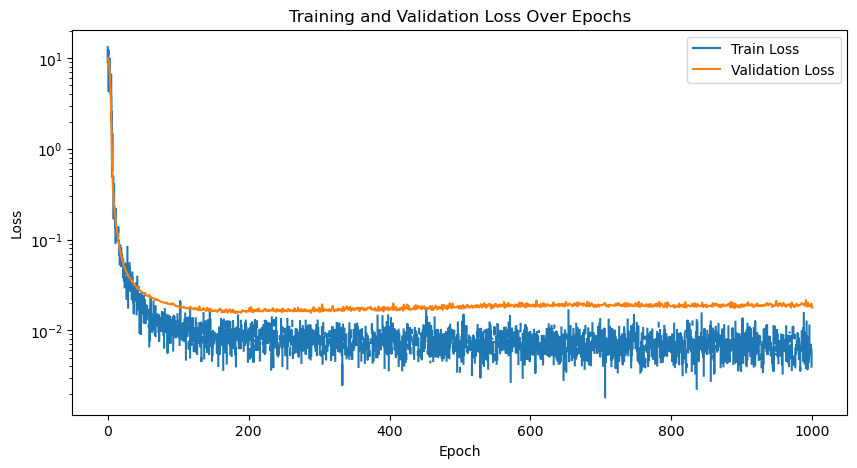

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(model_history['epoch'], model_history['train_loss'], label='Train Loss')
ax.plot(np.linspace(0, np.amax(model_history['epoch'])+1, 1+np.amax(model_history['epoch'])), model_history['val_loss'].dropna(), label='Validation Loss')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss Over Epochs')
ax.legend()

In [7]:
data = pd.read_csv('train_ds.csv')
X = data.drop(columns=['target']).values
y = data['target'].values

In [8]:
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().unsqueeze(1)

In [9]:
pruned_model, new_error_threshold, sensitivity_threshold = optimal_brain_surgeon(model, X_tensor, y_tensor)

Model Error: 0.009128154255449772


/Users/ashley/_conda_envs/envs/hess_sensitivity/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:46: RuntimeWarning: overflow encountered in multiply
  result = getattr(arr, method)(*args, **kwds)


Saliency: -0.2815, New Model Error: 0.1802
Saliency: -817.1830, New Model Error: 0.4570
Saliency: -342.0442, New Model Error: 3.8417
Saliency: -4586.3081, New Model Error: 4.4025
Saliency: -283.1215, New Model Error: 5.5698
Saliency: -17.5205, New Model Error: 5.5072
Saliency: -2.8190, New Model Error: 5.8247
Saliency: -0.3661, New Model Error: 6.7833
Saliency: -4621314.0000, New Model Error: 7.0518
Saliency: -13.6327, New Model Error: 7.8876
Saliency: -2.1614, New Model Error: 7.7256
Saliency: -0.8574, New Model Error: 8.3488
Saliency: -276.4347, New Model Error: 8.3870
Saliency: -1701.6769, New Model Error: 8.5548
Saliency: -23694.4082, New Model Error: 8.5544
Saliency: -502.9997, New Model Error: 8.6538
Saliency: -606.0577, New Model Error: 9.6497
Saliency: -214.1172, New Model Error: 9.7365
Saliency: -16.3502, New Model Error: 9.7358
Saliency: -38.2384, New Model Error: 9.8816
Saliency: -69.6516, New Model Error: 9.8717
Saliency: -183.2729, New Model Error: 9.8822
Saliency: -69.265

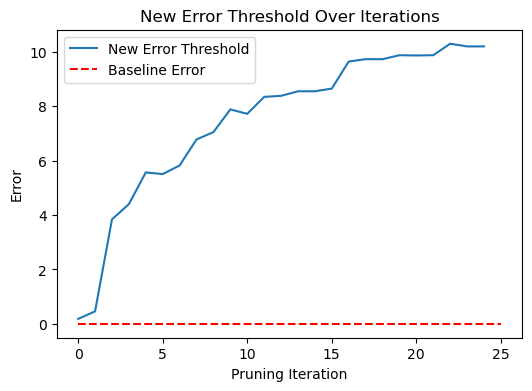

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(new_error_threshold, label='New Error Threshold')
ax.hlines(np.amin(model_history['train_loss']), 0, len(new_error_threshold), color='r', linestyle='--', label='Baseline Error')
ax.set_xlabel('Pruning Iteration')
ax.set_ylabel('Error')
ax.set_title('New Error Threshold Over Iterations')
ax.legend()
plt.show()